# TODO:


        # Continue bringng v5 over...
      
        ***1a) cross val: accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
        1b) further location cleaning / explanations for tfidf and count (and f1/precision/recall)
        1c) best way to present acc/prec/recall/f1 comparisons???
        1d) n-gram viz thing
        2) which countries most accurate in?
        3) why does RF and NB do better with count?
        4) BERT transfer learning? maybe?
        6) train unique RNN? ehhhhh

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re 
import string
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, plot, iplot

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import os
from os import path

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/cam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/cam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# Load in training data
train = pd.read_csv('Corona_NLP_train.csv', encoding = 'latin1')
# Copy training data
df = train.copy()
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
# Load in test data
test_df = pd.read_csv('Corona_NLP_test.csv', encoding = 'latin1')
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


## 2) Data Cleaning


In [24]:
# Check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
 6   newTweet       41157 non-null  object
 7   stemTweet      41157 non-null  object
 8   lemmaTweet     41157 non-null  object
 9   label          41157 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 3.1+ MB


In [25]:
# Replace na with 'None'
df['Location'].fillna('None', inplace = True)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,stemTweet,lemmaTweet,label
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,,,,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,coronaviru australia woolworth give elderli di...,coronavirus australia woolworth give elderly d...,1
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...,my food stock one empti pleas dont panic there...,my food stock one empty please dont panic ther...,1
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...,me readi go supermarket covid outbreak not im ...,me ready go supermarket covid outbreak not im ...,-1


In [8]:
# Join stopwords together and set them for use in cleaning function.
", ".join(stopwords.words('english'))
stops = set(stopwords.words('english'))

# Function that cleans tweets for classification. 
def clean_tweet(tweet):
    # Remove hyperlinks.
    tweet= re.sub(r'https?://\S+|www\.\S+','',tweet)
    # Remove html
    tweet = re.sub(r'<.*?>','',tweet)
    # Remove numbers (Do we want to remove numbers? Death toll?)
    tweet = re.sub(r'\d+','',tweet)
    # Remove mentions
    tweet = re.sub(r'@\w+','',tweet)
    # Remove punctuation
    tweet = re.sub(r'[^\w\s\d]','',tweet)
    # Remove whitespace
    tweet = re.sub(r'\s+',' ',tweet).strip()
    # Remove stopwords
    tweet = " ".join([word for word in str(tweet).split() if word not in stops])
    
    return tweet.lower()

In [9]:
# Check function
example2 = df['OriginalTweet'][1]
clean_tweet(example2)

'advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order'

In [10]:
# Apply text cleaning function to training and test dataframes.
df['newTweet'] = df['OriginalTweet'].apply(lambda x: clean_tweet(x))
test_df['newTweet'] = test_df['OriginalTweet'].apply(lambda x: clean_tweet(x))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...


In [11]:
def token_stem(tweet):
    tk = TweetTokenizer()
    stemmer = PorterStemmer()
    tweet = tk.tokenize(tweet)
    tweet = [stemmer.stem(word) for word in tweet]
    tweet =  tweet = " ".join([word for word in tweet])
    return tweet

In [12]:
def token_lemma(tweet):
    tk = TweetTokenizer()
    lemma = WordNetLemmatizer()
    tweet = tk.tokenize(tweet)
    tweet = [lemma.lemmatize(word) for word in tweet]
    tweet = " ".join([word for word in tweet])
    return tweet

In [13]:
tweet = df['newTweet'][1]
tweet

'advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order'

In [15]:
print(token_stem(tweet))
print('\n')
print(token_lemma(tweet))

advic talk neighbour famili exchang phone number creat contact list phone number neighbour school employ chemist gp set onlin shop account poss adequ suppli regular med order


advice talk neighbour family exchange phone number create contact list phone number neighbour school employer chemist gp set online shopping account po adequate supply regular med order


In [16]:
df['stemTweet'] = df['newTweet'].apply(lambda x: token_stem(x))
df['lemmaTweet'] = df['newTweet'].apply(lambda x: token_lemma(x))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,stemTweet,lemmaTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,,,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,coronaviru australia woolworth give elderli di...,coronavirus australia woolworth give elderly d...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...,my food stock one empti pleas dont panic there...,my food stock one empty please dont panic ther...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...,me readi go supermarket covid outbreak not im ...,me ready go supermarket covid outbreak not im ...


In [17]:
# Create more useful labels for classification.
# We will take the original 5 possibilites and
# reduce them to 3, removing the "extremelys".
def make_label(sentiment):
    
    label = ''
    if 'Positive' in sentiment: 
        label = 1
    if 'Negative' in sentiment:
        label = -1
    if 'Neutral' in sentiment:
        label = 0
    return label

In [18]:
# Apply make_label funtion to training and test dataframes.
df['label'] = df['Sentiment'].apply(lambda x: make_label(x))
test_df['label'] = test_df['Sentiment'].apply(lambda x: make_label(x))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,stemTweet,lemmaTweet,label
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,,,,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,coronaviru australia woolworth give elderli di...,coronavirus australia woolworth give elderly d...,1
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...,my food stock one empti pleas dont panic there...,my food stock one empty please dont panic ther...,1
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...,me readi go supermarket covid outbreak not im ...,me ready go supermarket covid outbreak not im ...,-1


In [19]:
# Some frequent US locations
us_filters = ('New York', 'New York, NY', 'NYC', 'NY', 'Washington, DC', 'Los Angeles, CA',
             'Seattle, Washington', 'Chicago', 'Chicago, IL', 'California, USA', 'Atlanta, GA',
             'San Francisco, CA', 'Boston, MA', 'New York, USA', 'Texas, USA', 'Austin, TX',
              'Houston, TX', 'New York City', 'Philadelphia, PA', 'Florida, USA', 'Seattle, WA',
             'Washington, D.C.', 'San Diego, CA', 'Las Vegas, NV', 'Dallas, TX', 'Denver, CO',
             'New Jersey, USA', 'Brooklyn, NY', 'California', 'Michigan, USA', 'Minneapolis, MN',
             'Virginia, USA', 'Miami, FL', 'Texas', 'Los Angeles', 'United States', 'San Francisco',
             'Indianapolis, IN', 'Pennsylvania, USA', 'Phoenix, AZ', 'New Jersey', 'Baltimore, MD',
             'CA', 'FL', 'DC', 'TX', 'IL', 'MA', 'PA', 'GA', 'NC', 'NJ', 'WA', 'VA', 'PAK', 'MI', 'OH',
             'CO', 'AZ', 'D.C.', 'WI', 'MD', 'MO', 'TN', 'Florida', 'IN', 'NV', 'MN', 'OR','LA', 'Michigan',
             'CT', 'SC', 'OK', 'Illinois', 'Ohio', 'UT', 'KY', 'Arizona', 'Colorado')

# Various nation's frequent locations
uk_filters = ('England', 'London', 'london', 'United Kingdom', 'united kingdom',
              'England, United Kingdom', 'London, UK', 'London, England',
              'Manchester, England', 'Scotland, UK', 'Scotland', 'Scotland, United Kingdom',
              'Birmingham, England', 'UK', 'Wales')
india_filters = ('New Delhi, India', 'Mumbai', 'Mumbai, India', 'New Delhi', 'India', 
                 'Bengaluru, India')
australia_filters = ('Sydney, Australia', 'New South Wales', 'Melbourne, Australia', 'Sydney',
                     'Sydney, New South Wales', 'Melbourne, Victoria', 'Melbourne', 'Australia')
canada_filters = ('Toronto, Ontario', 'Toronto', 'Ontario, Canada', 'Toronto, Canada', 'Canada',
                  'Vancouver, British Columbia', 'Ontario', 'Victoria', 'British Columbia', 'Alberta',)
south_africa_filters = ('Johannesburg, South Africa', 'Cape Town, South Africa', 'South Africa')
nigeria_filters = ('Lagos, Nigeria')
kenya_filters = ('Nairobi, Kenya')
france_filters = ('Paris, France')
ireland_filters = ('Ireland')
new_zealand_filters = ('New Zealand')
pakistan_filters = ('Pakistan')
malaysia_filters = ('Malaysia')
uganda_filters = ('Kampala, Uganda', 'Uganda')
singapore_filters = ('Singapore')
germany_filters = ('Germany', 'Deutschland')
switz_filters = ('Switzerland')
uae_filters = ('United Arab Emirates', 'Dubai')
spain_filters = ('Spain')
belg_filters = ('Belgium')
phil_filters = ('Philippines')
hk_filters = ('Hong Kong')
ghana_filters = ('Ghana')
# These all have large counts. Need to be removed from rest of data
other_filters = ('None', 'Worldwide', 'Global', 'Earth', '??')

In [26]:
df['country'] = df['Location'].apply(lambda x: x.split(",")[-1].strip() if ("," in x) else x)

In [23]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,stemTweet,lemmaTweet,label
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,,,,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,coronaviru australia woolworth give elderli di...,coronavirus australia woolworth give elderly d...,1
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...,my food stock one empti pleas dont panic there...,my food stock one empty please dont panic ther...,1
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...,me readi go supermarket covid outbreak not im ...,me ready go supermarket covid outbreak not im ...,-1


In [38]:
# Changing strings found with filters into 3 digit codes
df['country'] = df['country'].apply(lambda x: 'USA' if x in us_filters else x)
df['country'] = df['country'].apply(lambda x: 'GBR' if x in uk_filters else x)
df['country'] = df['country'].apply(lambda x: 'IND' if x in india_filters else x)
df['country'] = df['country'].apply(lambda x: 'AUS' if x in australia_filters else x)
df['country'] = df['country'].apply(lambda x: 'CAN' if x in canada_filters else x)
df['country'] = df['country'].apply(lambda x: 'ZAF' if x in south_africa_filters else x)
df['country'] = df['country'].apply(lambda x: 'KEN' if x in kenya_filters else x)
df['country'] = df['country'].apply(lambda x: 'NGA' if x in nigeria_filters else x)
df['country'] = df['country'].apply(lambda x: 'SGP' if x in singapore_filters else x)
df['country'] = df['country'].apply(lambda x: 'FRA' if x in france_filters else x)
df['country'] = df['country'].apply(lambda x: 'NZL' if x in new_zealand_filters else x)
df['country'] = df['country'].apply(lambda x: 'PAK' if x in pakistan_filters else x)
df['country'] = df['country'].apply(lambda x: 'MYS' if x in malaysia_filters else x)
df['country'] = df['country'].apply(lambda x: 'IRL' if x in ireland_filters else x)
df['country'] = df['country'].apply(lambda x: 'UGA' if x in uganda_filters else x)
df['country'] = df['country'].apply(lambda x: 'DEU' if x in germany_filters else x)
df['country'] = df['country'].apply(lambda x: 'CHE' if x in switz_filters else x)
df['country'] = df['country'].apply(lambda x: 'ARE' if x in uae_filters else x)
df['country'] = df['country'].apply(lambda x: 'ESP' if x in spain_filters else x)
df['country'] = df['country'].apply(lambda x: 'BEL' if x in belg_filters else x)
df['country'] = df['country'].apply(lambda x: 'PHL' if x in phil_filters else x)
df['country'] = df['country'].apply(lambda x: 'GHA' if x in ghana_filters else x)
df['country'] = df['country'].apply(lambda x: 'HKG' if x in hk_filters else x)
df['country'] = df['country'].apply(lambda x: 'None' if x in other_filters else x)

In [39]:
df['country'].value_counts()

USA                      9813
None                     8980
GBR                      3811
CAN                      1233
IND                      1097
                         ... 
United Arab Emirate         1
On Your iPod                1
United Kingdom Dorset       1
U.S. of A.                  1
Makerere university         1
Name: country, Length: 7312, dtype: int64

In [40]:
# 0:24 because that's where the labeled countries end
places_df = pd.DataFrame(df['country'].value_counts()[0:30])
places_df.reset_index(inplace = True)
places_df.rename(columns = {'index':'Country', 'country':'Tweets'}, inplace = True)
# Remove 'None' location
places_df = places_df[places_df['Country'] != 'None']

In [41]:
data = dict(type='choropleth',
            colorscale = 'inferno',
            locations = places_df['Country'],
            z = places_df['Tweets'],
            #locationmode = 'USA-states',
            text = places_df['Tweets'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 2)),
            colorbar = {'title':"Number of Tweets"}
            ) 

layout = dict(title = 'Number of Tweets By Country',
              geo = dict(#scope='usa',
                         showlakes = False,
                         lakecolor = 'rgb(85,173,240)',
                         projection_type='equirectangular')
             )

choromap = go.Figure(data = [data],layout = layout)

In [42]:
iplot(choromap)

In [43]:
# image courtesy of https://tse2.mm.bing.net/th?id=OIP.VLv_PpEOc8TDwuTNvj5hWQHaHa&pid=Api
mask = np.array(Image.open("rona4.jpeg"))

# Positive WordCloud
pos_df = df[df['label'] == 1]
pos_text = pos_df['newTweet'].to_string(index = False)
pos_text = re.sub(r'\n','',pos_text)
pos_cloud = WordCloud(colormap = 'Greens', mask = mask).generate(pos_text)

# Neutral WordCloud
neut_df = df[df['label'] == 0]
neut_text = neut_df['newTweet'].to_string(index = False)
neut_text = re.sub(r'\n','', neut_text)
neut_cloud = WordCloud(colormap = 'Blues', mask = mask).generate(neut_text)

# Negative wordcloud
neg_df = df[df['label'] == -1]
neg_text = neg_df['newTweet'].to_string(index = False)
neg_text = re.sub(r'\n','', neg_text)
neg_cloud = WordCloud(colormap = 'Reds', mask = mask).generate(neg_text)

(-0.5, 473.5, 473.5, -0.5)

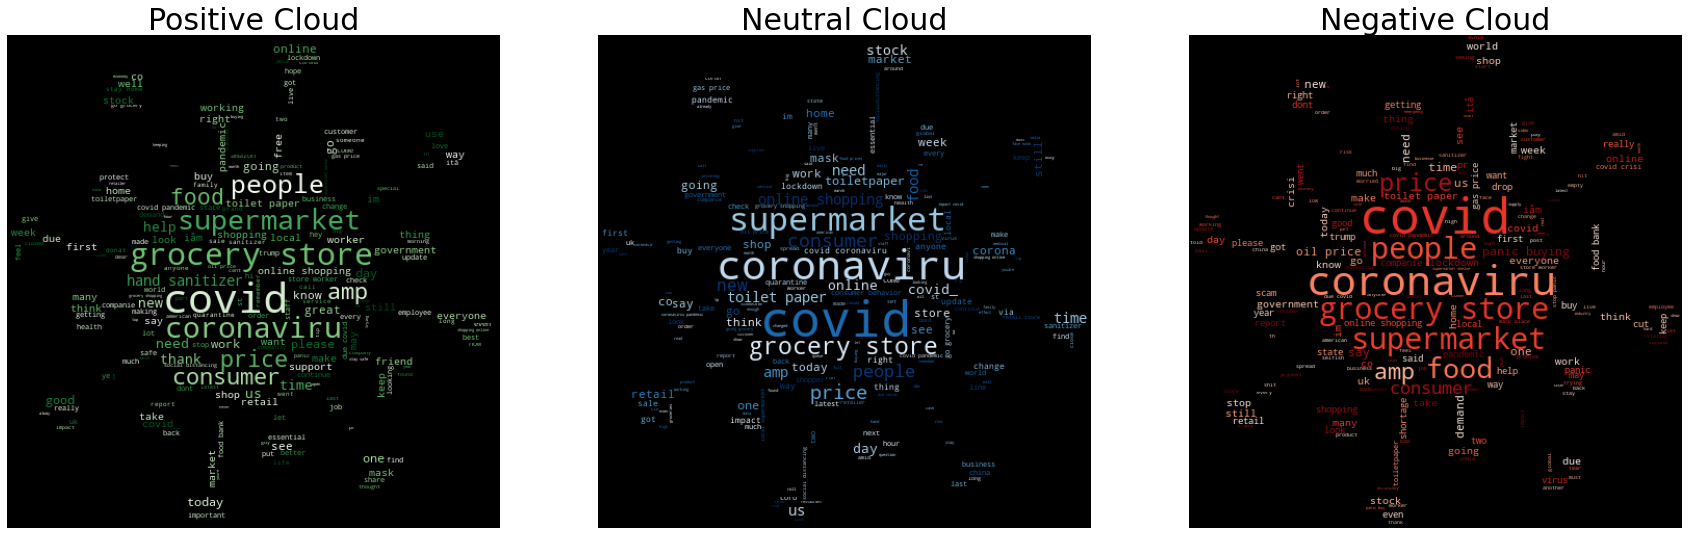

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = [30,20])
ax1.imshow(pos_cloud)
ax1.set_title('Positive Cloud', fontsize = 30)
ax1.axis('off')
ax2.imshow(neut_cloud)
ax2.set_title('Neutral Cloud', fontsize = 30)
ax2.axis('off')
ax3.imshow(neg_cloud)
ax3.set_title('Negative Cloud', fontsize = 30)
ax3.axis('off')

Tried to use an image of the coronavirus for the mask, it certainly could have turned out better...
'Grocery store', 'price', 'supermarket', and 'online shopping' being frequent in positive, neutral, and negative tweets is interesting.  Some stand-out negative terms are 'panic buying' and 'toilet paper'. For positive, 'hand sanitizer' catches my attention. 

## 4) Classification

In [46]:
# Set X and y.
X = df['newTweet']
y = df['label']

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [47]:
# Function that will iterate through models and print 
# classifcation reports and accuracies for each model.
def models(clf, vectorizer, X_train, X_test, y_train, y_test):
    """
    Input:
        clf: dictionary containing classification methods
        vectorizer: ex TfidfVectorizer, CountVectorizer
        X_train: X training data
        X_test: X testing data
        y_train: y training labels
        y_test: y testing label
    
    Output: 
        output_df: a DataFrame containing the weighted average
        accuracy, precision, recall, and f1 score of each method
    """
    
    accuracy_dict = {}
    clf_dict = {}
    precision_dict = {}
    recall_dict = {}
    f1_dict = {}
    for classifier in clf.keys():
        model = Pipeline([('vectorizer',vectorizer),
                    ('clf', clf[classifier]),
                    ])
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
        accuracy_dict[classifier] = accuracy_score(y_test,preds)
        clf_dict[classifier] = classification_report(y_test,preds, output_dict = True)
        precision_dict[classifier] = clf_dict[classifier]['weighted avg']['precision']
        recall_dict[classifier] = clf_dict[classifier]['weighted avg']['recall']
        f1_dict[classifier] = clf_dict[classifier]['weighted avg']['f1-score']
           
        print(classifier)
        print(classification_report(y_test,preds))
        print(classifier + ' Accuracy:', accuracy_score(y_test,preds))
        print('\n')
    
    acc_df = pd.DataFrame.from_dict(accuracy_dict, orient = 'index', columns = ['accuracy'])
    acc_df.reset_index(inplace = True)
    acc_df.columns = ['method', 'accuracy']
    
    precision_df = pd.DataFrame.from_dict(precision_dict, orient = 'index', columns = ['precision'])
    precision_df.reset_index(inplace = True)
    precision_df.columns = ['method', 'precision']
    
    recall_df = pd.DataFrame.from_dict(recall_dict, orient = 'index', columns = ['recall'])
    recall_df.reset_index(inplace = True)
    recall_df.columns = ['method', 'recall']
    
    f1_df = pd.DataFrame.from_dict(f1_dict, orient = 'index', columns = ['f1-score'])
    f1_df.reset_index(inplace = True)
    f1_df.columns = ['method', 'f1-score']
    
    output_df = acc_df.set_index('method').join(precision_df.set_index('method'))
    output_df = output_df.join(recall_df.set_index('method'))
    output_df = output_df.join(f1_df.set_index('method'))
    output_df.reset_index(inplace = True)
    
    return output_df

In [48]:
# takes a while...
models = [
    #RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    #LogisticRegression(max_iter = 5000),
    MultinomialNB(),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

NameError: name 'features' is not defined

In [63]:
pipe = Pipeline([('vectorizer',TfidfVectorizer()),
            ('clf', LinearSVC()),
            ])
pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)

In [79]:
pipe

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('clf', LinearSVC())])

'Pipeline'

In [57]:
scores = cross_val_score(model, X_train, y_train, cv = 5)

In [65]:
scores

array([0.79035057, 0.79538355, 0.79312739, 0.78340854, 0.78475959])

In [70]:
clf = dict({'SVC': LinearSVC(max_iter = 5000),
            #'Logisitc': LogisticRegression(max_iter = 5000),
            'NaiveBayes': MultinomialNB(),
            #'RandomForest': RandomForestClassifier(),
           })

In [84]:
def make_models(clf, vectorizer, X_train, y_train, cv = 5):
    
    cv = cv
    acc_df = pd.DataFrame(index=range(CV * len(models)))
    results = []
    for classifier in clf.keys():
        model = Pipeline([('vectorizer',vectorizer),
                    ('clf', clf[classifier])])
        scores = cross_val_score(model, X_train, y_train, cv = 5)
        model_name = classifier
        for fold, score in enumerate(scores):
            results.append((model_name, fold, score))
    
    acc_df = pd.DataFrame(results, columns=['model_name', 'fold_idx', 'accuracy'])
    
    return acc_df

In [85]:
tfidf_df = make_models(clf, TfidfVectorizer(), X_train, y_train, 5)

In [86]:
tfidf_df

,model_name,fold_idx,accuracy
0,SVC,0,0.790351
1,SVC,1,0.795384
2,SVC,2,0.793127
3,SVC,3,0.783409
4,SVC,4,0.784760
5,NaiveBayes,0,0.625130
6,NaiveBayes,1,0.636237
7,NaiveBayes,2,0.632246
8,NaiveBayes,3,0.633634
9,NaiveBayes,4,0.633223


ValueError: Could not interpret input 'model_name'

<Figure size 576x360 with 0 Axes>